# Visualization

## Loss History

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

plt.style.use('dark_background')

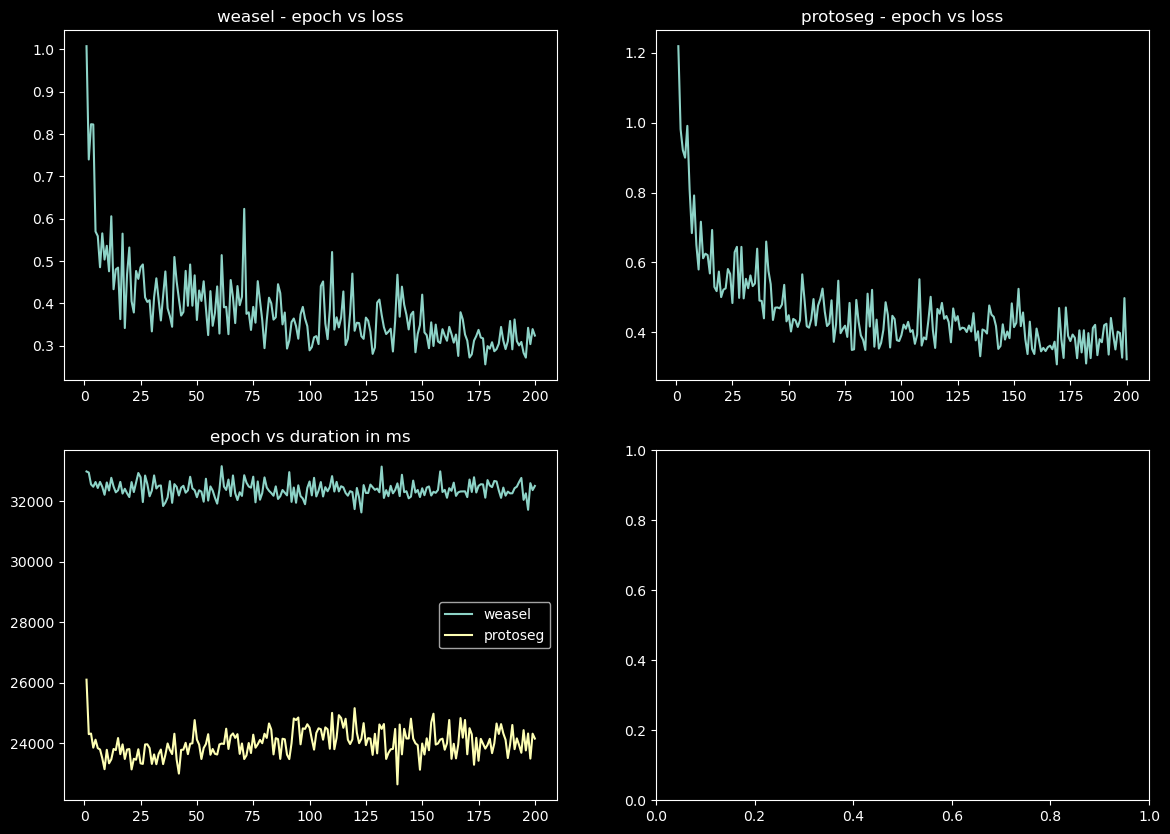

In [2]:
weasel_train_loss = pd.read_csv('outputs/weasel_long_rimone_to_drishti/train_loss.csv')
protoseg_train_loss = pd.read_csv('outputs/protoseg_long_rimone_to_drishti/train_loss.csv')

_, axs = plt.subplots(2, 2, figsize=(14,10))

axs[0][0].set_title('weasel - epoch vs loss')
axs[0][0].plot(weasel_train_loss['epoch'], weasel_train_loss['loss'])

axs[0][1].set_title('protoseg - epoch vs loss')
axs[0][1].plot(protoseg_train_loss['epoch'], protoseg_train_loss['loss'])

axs[1][0].set_title('epoch vs duration in ms')
axs[1][0].plot(weasel_train_loss['epoch'], weasel_train_loss['duration'], label = 'weasel')
axs[1][0].plot(protoseg_train_loss['epoch'], protoseg_train_loss['duration'], label = 'protoseg')
axs[1][0].legend()

## Score History

(0.0, 1.0)

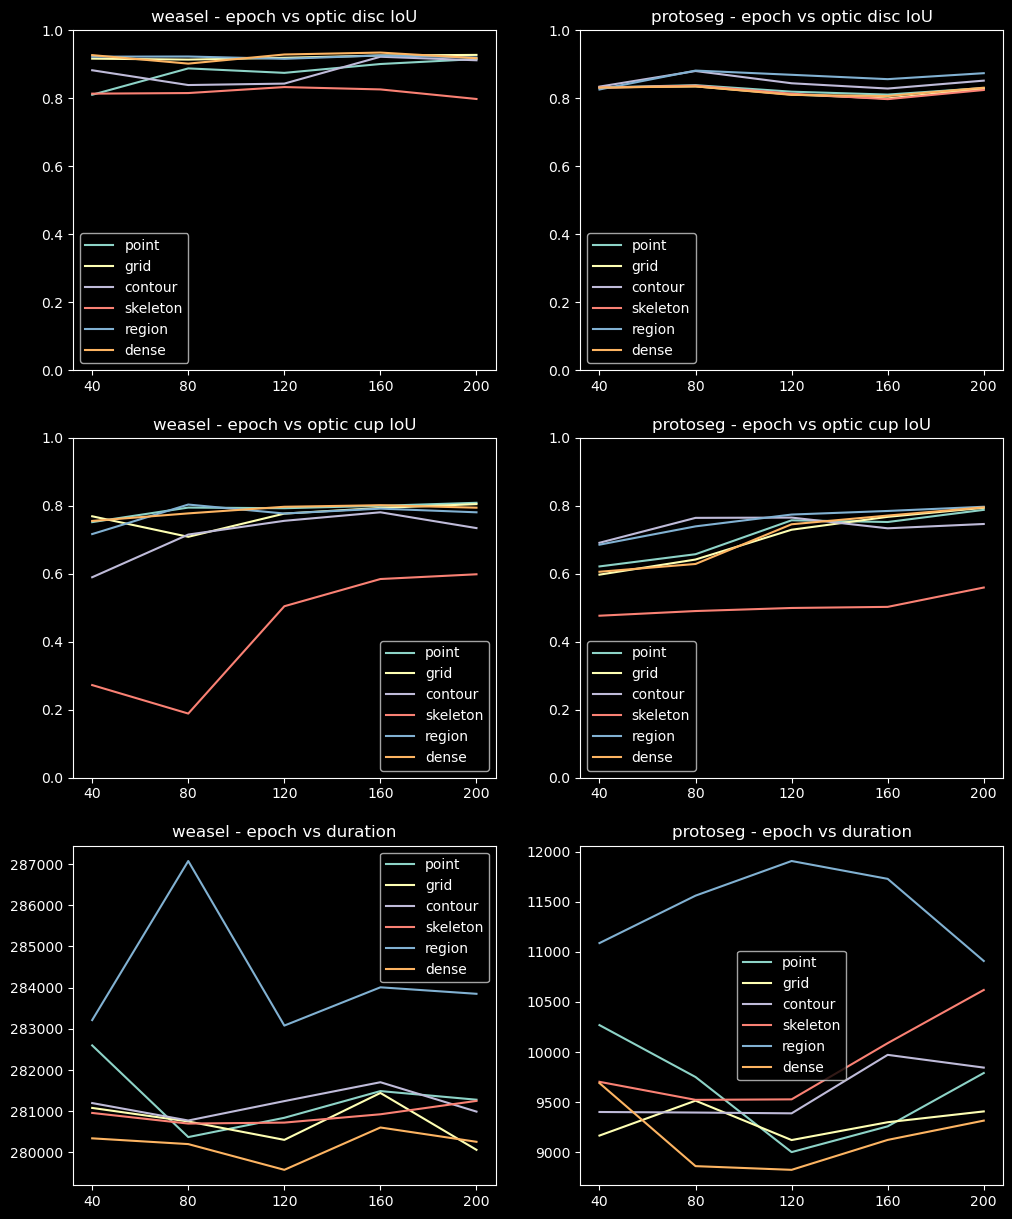

In [9]:
weasel_tuned_score = pd.read_csv('outputs/weasel_long_rimone_to_drishti/tuned_score.csv')
protoseg_tuned_score = pd.read_csv('outputs/protoseg_long_rimone_to_drishti/tuned_score.csv')

sparsity_modes = ['point', 'grid', 'contour', 'skeleton', 'region', 'dense']

_, axs = plt.subplots(3, 2, figsize=(12,15))

for sm in sparsity_modes:
    weasel_df = weasel_tuned_score[weasel_tuned_score['sparsity_mode'] == sm]
    weasel_epochs = [str(ep) for ep in weasel_df['epoch']]
    axs[0][0].plot(weasel_epochs, weasel_df['iou_od'], label = sm)
    axs[1][0].plot(weasel_epochs, weasel_df['iou_oc'], label = sm)
    axs[2][0].plot(weasel_epochs, weasel_df['duration'], label = sm)

    protoseg_df = protoseg_tuned_score[protoseg_tuned_score['sparsity_mode'] == sm]
    protoseg_epochs = [str(ep) for ep in protoseg_df['epoch']]
    axs[0][1].plot(protoseg_epochs, protoseg_df['iou_od'], label = sm)
    axs[1][1].plot(protoseg_epochs, protoseg_df['iou_oc'], label = sm)
    axs[2][1].plot(protoseg_epochs, protoseg_df['duration'], label = sm)

axs[0][0].set_title('weasel - epoch vs optic disc IoU')
axs[1][0].set_title('weasel - epoch vs optic cup IoU')
axs[2][0].set_title('weasel - epoch vs duration')
axs[0][0].legend()
axs[1][0].legend()
axs[2][0].legend()
axs[0][0].set_ylim([0, 1])
axs[1][0].set_ylim([0, 1])
axs[0][1].set_title('protoseg - epoch vs optic disc IoU')
axs[1][1].set_title('protoseg - epoch vs optic cup IoU')
axs[2][1].set_title('protoseg - epoch vs duration')
axs[0][1].legend()
axs[1][1].legend()
axs[2][1].legend()
axs[0][1].set_ylim([0, 1])
axs[1][1].set_ylim([0, 1])

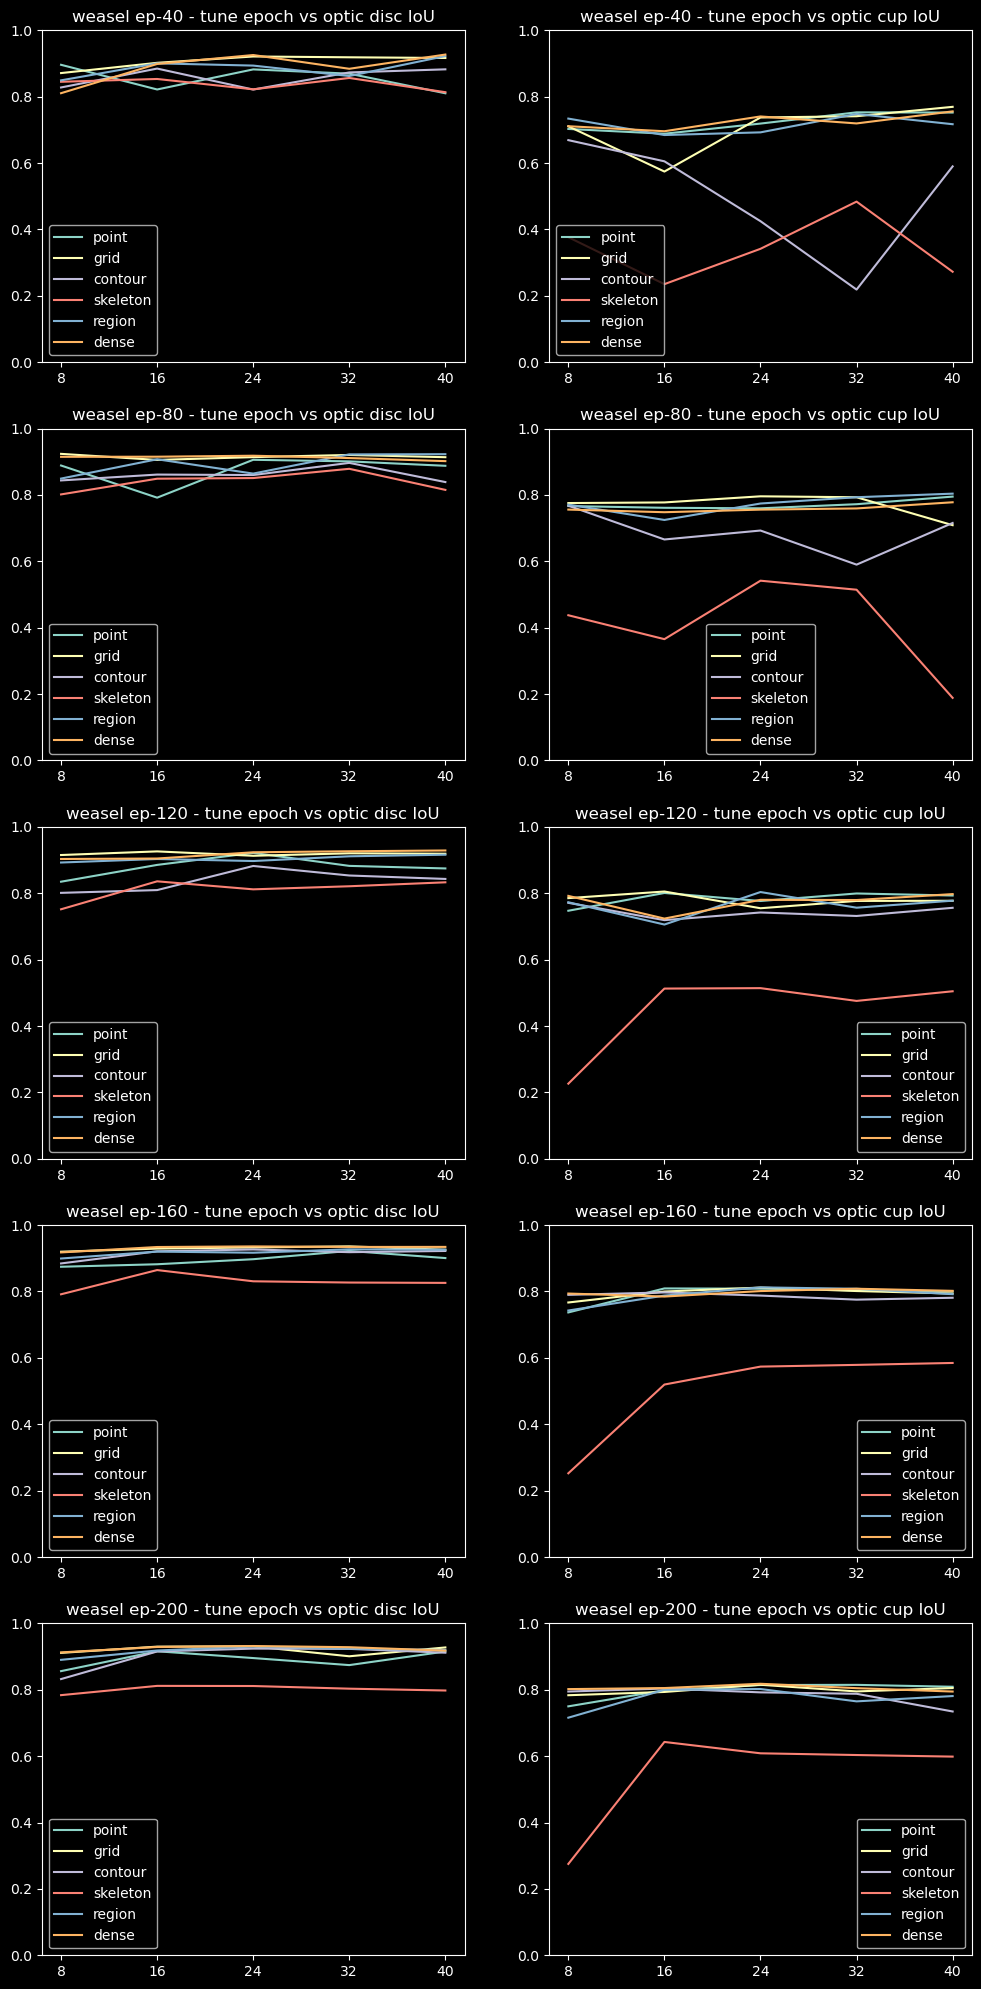

In [7]:
weasel_tuning_score = pd.read_csv('outputs/weasel_long_rimone_to_drishti/tuning_score.csv')
weasel_epochs = weasel_tuning_score['epoch'].unique()

sparsity_modes = ['point', 'grid', 'contour', 'skeleton', 'region', 'dense']

_, axs = plt.subplots(len(weasel_epochs), 2, figsize=(12,5*len(weasel_epochs)))

for i, ep in enumerate(weasel_epochs):
    for sm in sparsity_modes:
        weasel_df = weasel_tuning_score[(weasel_tuning_score['sparsity_mode'] == sm) & (weasel_tuning_score['epoch'] == ep)]
        weasel_tune_epochs = [str(tep) for tep in weasel_df['tune_epoch']]
        axs[i][0].plot(weasel_tune_epochs, weasel_df['iou_od'], label = sm)
        axs[i][1].plot(weasel_tune_epochs, weasel_df['iou_oc'], label = sm)
        # axs[i][2].plot(weasel_tune_epochs, weasel_df['test_duration'], label = sm)

    axs[i][0].set_title(f'weasel ep-{ep} - tune epoch vs optic disc IoU')
    axs[i][1].set_title(f'weasel ep-{ep} - tune epoch vs optic cup IoU')
    # axs[i][2].set_title(f'weasel ep-{ep} - tune epoch vs test duration')
    axs[i][0].legend()
    axs[i][1].legend()
    # axs[i][2].legend()
    axs[i][0].set_ylim([0, 1])
    axs[i][1].set_ylim([0, 1])

# Other